In [7]:
import matplotlib.pyplot as plt
#the jax library itself, and the library of optimizers we will use for training
import jax, optax
#the jax version of numpy
import jax.numpy as jnp
#equinox, the package with the machine learning structures pre-built and ready to use
import equinox as eqx

# Learning `sinc(x)`

We will be generating a multilayer perceptron (MLP) to use as our deep network to optimize. This uses the `equinox` package, the same package used to generate the MLPs used in the exchange/correlation networks in `xcquinox`.

In [13]:
NODES = 32
DEPTH = 4
SEED = 92017

class sincNet(eqx.Module):
    depth: int
    nodes: int
    seed: int
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we will use jax.vmap to broadcast the calculation 
        # across the input array
        return self.net(inp)

net = sincNet(depth=DEPTH, nodes=NODES, seed=SEED)

We will focus our learning on a symmetric mesh of x-values.

In [14]:
MAGNITUDE = 3
NPTS = 200
inps = jnp.linspace(-MAGNITUDE, MAGNITUDE, num = NPTS, endpoint = True)
refs = jnp.sinc(inps)
grefs = jax.vmap(jax.grad(jnp.sinc))(inps)

Let's see what we're trying to learn. The vertical lines bound the region being learned.

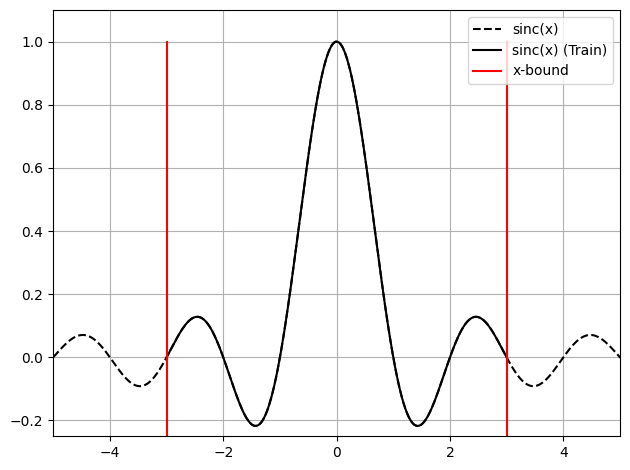

In [15]:
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.sinc(extrax), 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.plot(-MAGNITUDE*onesy, verty, 'r-', label='x-bound')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.legend()
plt.tight_layout()

As a descriptive example of how useful the randomly initialized network is, let's see its output in this range.

In [16]:
#jnp.newaxis just gives the inps array a shape of (NPTS, 1) instead of (NPTS,)
init_preds = jax.vmap(net)(inps[:, jnp.newaxis])

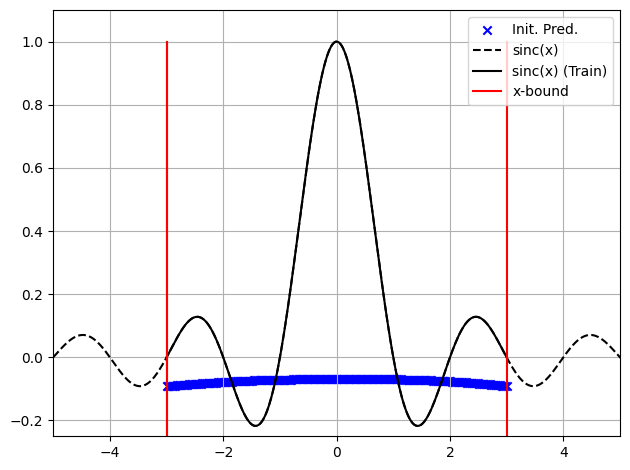

In [17]:
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.scatter(inps, init_preds, color='b', marker='x', label='Init. Pred.')
plt.plot(extrax, jnp.sinc(extrax), 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.plot(-MAGNITUDE*onesy, verty, 'r-', label='x-bound')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.legend()
plt.grid()
plt.tight_layout()

We will go through the training process using the `equinox` package. Now we build the training loop, within which we place the loss calculation and update function.

In [20]:
def loop(model, inp, ref, optimizer, epochs=1000000, printevery = 2500):
    #define the loss function
    @eqx.filter_value_and_grad
    def compute_loss(model, inp, ref):
        pred = jax.vmap(model)(inp)
        loss = jnp.sqrt(jnp.mean( (pred-ref)**2))
        return loss
    
    #define an update function to optimize the network
    @eqx.filter_jit
    def make_step(model, inp, ref, opt_state):
        loss, grad = compute_loss(model, inp, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []
    for step in range(epochs):
        loss, model, opt_state = make_step(model, inp, ref, opt_state)
        loss = loss.item()
        losses.append(loss)
        if step%printevery == 0:
            print(f'Epoch {step}: Loss = {loss}')

    return model, losses

We use the ADAM optimizer with an initial learning rate as set below, as well as one with an exponential decay schedule to generate two sinc networks to compare.

In [21]:
LR = 0.01
EPOCHS = 25000
DECAYSTART = EPOCHS//10
TRANSITION_STEPS = EPOCHS-DECAYSTART
DECAY_RATE = 0.8
scheduler = optax.exponential_decay(init_value = LR, transition_begin=DECAYSTART,
                                    transition_steps = TRANSITION_STEPS,
                                    decay_rate = DECAY_RATE)
optim = optax.adam(LR)
optimExp = optax.adam(learning_rate = scheduler)

In [22]:
newnet, losses = loop(net, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optim, epochs=EPOCHS)

Epoch 0: Loss = 0.4370814561843872
Epoch 2500: Loss = 0.005187768489122391
Epoch 5000: Loss = 0.004137073177844286
Epoch 7500: Loss = 0.008110249415040016
Epoch 10000: Loss = 0.004347707144916058
Epoch 12500: Loss = 0.003226224333047867
Epoch 15000: Loss = 0.00396863603964448
Epoch 17500: Loss = 0.005361134186387062
Epoch 20000: Loss = 0.0025139502249658108
Epoch 22500: Loss = 0.0039630769751966


In [23]:
newnetExp, lossesExp = loop(net, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.4370814561843872
Epoch 2500: Loss = 0.005187768489122391
Epoch 5000: Loss = 0.0031475082505494356
Epoch 7500: Loss = 0.0030025187879800797
Epoch 10000: Loss = 0.0030746276024729013
Epoch 12500: Loss = 0.005131366662681103
Epoch 15000: Loss = 0.003207336412742734
Epoch 17500: Loss = 0.002477266825735569
Epoch 20000: Loss = 0.0033189821988344193
Epoch 22500: Loss = 0.0025005508214235306


Just to see what happens, we now feed in `newnet` to the scheduled optimization to see how it may improve.

In [25]:
newnet2, losses2 = loop(newnet, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.0029891326557844877
Epoch 2500: Loss = 0.0028294450603425503
Epoch 5000: Loss = 0.0026814285665750504
Epoch 7500: Loss = 0.003975348547101021
Epoch 10000: Loss = 0.0026792152784764767
Epoch 12500: Loss = 0.003555294359102845
Epoch 15000: Loss = 0.002173075685277581
Epoch 17500: Loss = 0.002290236297994852
Epoch 20000: Loss = 0.0021213225554674864
Epoch 22500: Loss = 0.001824069651775062


Now let's see how these do on the training region.

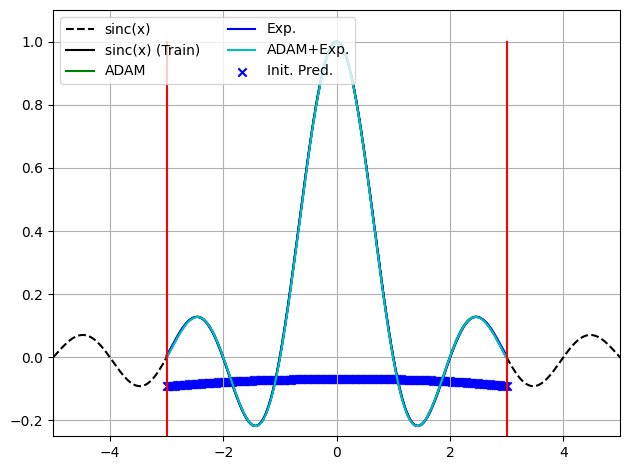

In [27]:
newnet_preds = jax.vmap(newnet)(inps[:, jnp.newaxis])
newnetExp_preds = jax.vmap(newnetExp)(inps[:, jnp.newaxis])
newnet2_preds = jax.vmap(newnet2)(inps[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
extray = jnp.sinc(extrax)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.plot(inps, newnet_preds, 'g-', label='ADAM')
plt.plot(inps, newnetExp_preds, 'b-', label='Exp.')
plt.plot(inps, newnet2_preds, 'c-', label='ADAM+Exp.')
plt.scatter(inps, init_preds, color='b', marker='x', label='Init. Pred.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.grid()
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()

It seems well-aligned, so let's plot the absolute deviation from reference for the networks.

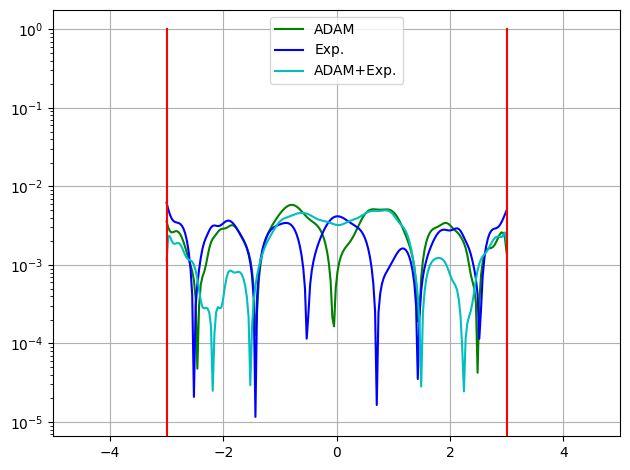

In [28]:
newnet_preds = jax.vmap(newnet)(inps[:, jnp.newaxis])
newnetExp_preds = jax.vmap(newnetExp)(inps[:, jnp.newaxis])
newnet2_preds = jax.vmap(newnet2)(inps[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(inps, jnp.abs(newnet_preds-refs[:, jnp.newaxis]), 'g-', label='ADAM')
plt.plot(inps, jnp.abs(newnetExp_preds-refs[:, jnp.newaxis]), 'b-', label='Exp.')
plt.plot(inps, jnp.abs(newnet2_preds-refs[:, jnp.newaxis]), 'c-', label='ADAM+Exp.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.grid()
plt.legend()
plt.tight_layout()

How about the network's generalization beyond the training region?

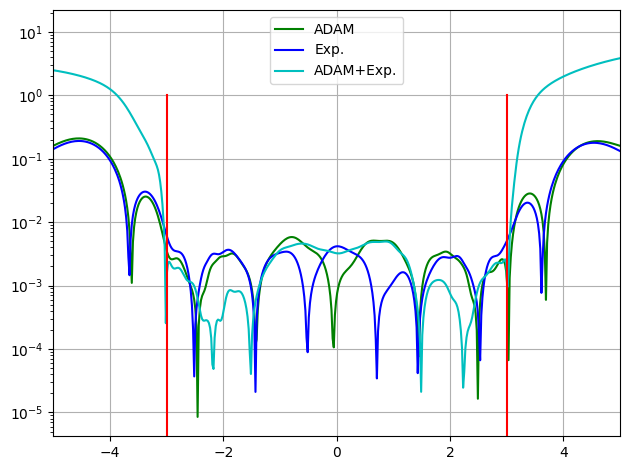

In [29]:
newnet_preds2 = jax.vmap(newnet)(extrax[:, jnp.newaxis])
newnetExp_preds2 = jax.vmap(newnetExp)(extrax[:, jnp.newaxis])
newnet2_preds2 = jax.vmap(newnet2)(extrax[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.abs(newnet_preds2-extray[:, jnp.newaxis]), 'g-', label='ADAM')
plt.plot(extrax, jnp.abs(newnetExp_preds2-extray[:, jnp.newaxis]), 'b-', label='Exp.')
plt.plot(extrax, jnp.abs(newnet2_preds2-extray[:, jnp.newaxis]), 'c-', label='ADAM+Exp.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.legend()
plt.grid()
plt.tight_layout()

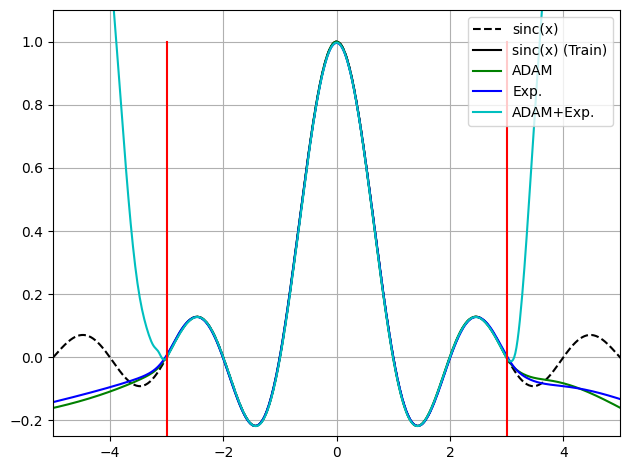

In [30]:
newnet_preds2 = jax.vmap(newnet)(extrax[:, jnp.newaxis])
newnetExp_preds2 = jax.vmap(newnetExp)(extrax[:, jnp.newaxis])
newnet2_preds2 = jax.vmap(newnet2)(extrax[:, jnp.newaxis])

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.plot(extrax, newnet_preds2, 'g-', label='ADAM')
plt.plot(extrax, newnetExp_preds2, 'b-', label='Exp.')
plt.plot(extrax, newnet2_preds2, 'c-', label='ADAM+Exp.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.legend()
plt.grid()
plt.tight_layout()

So the network learns the bounded region reasonably well, but does it learn the gradients well or no?

In [31]:
jax.grad?

Signature:
jax.grad(
    fun: 'Callable',
    argnums: 'int | Sequence[int]' = 0,
    has_aux: 'bool' = False,
    holomorphic: 'bool' = False,
    allow_int: 'bool' = False,
    reduce_axes: 'Sequence[AxisName]' = (),
) -> 'Callable'
Docstring:
Creates a function that evaluates the gradient of ``fun``.

Args:
  fun: Function to be differentiated. Its arguments at positions specified by
    ``argnums`` should be arrays, scalars, or standard Python containers.
    Argument arrays in the positions specified by ``argnums`` must be of
    inexact (i.e., floating-point or complex) type. It
    should return a scalar (which includes arrays with shape ``()`` but not
    arrays with shape ``(1,)`` etc.)
  argnums: Optional, integer or sequence of integers. Specifies which
    positional argument(s) to differentiate with respect to (default 0).
  has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
    first element is considered the output of the mathematical function to

In [32]:
jax.jacobian?

Signature:
jax.jacobian(
    fun: 'Callable',
    argnums: 'int | Sequence[int]' = 0,
    has_aux: 'bool' = False,
    holomorphic: 'bool' = False,
    allow_int: 'bool' = False,
) -> 'Callable'
Docstring:
Jacobian of ``fun`` evaluated row-by-row using reverse-mode AD.

Args:
  fun: Function whose Jacobian is to be computed.
  argnums: Optional, integer or sequence of integers. Specifies which
    positional argument(s) to differentiate with respect to (default ``0``).
  has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
    first element is considered the output of the mathematical function to be
    differentiated and the second element is auxiliary data. Default False.
  holomorphic: Optional, bool. Indicates whether ``fun`` is promised to be
    holomorphic. Default False.
  allow_int: Optional, bool. Whether to allow differentiating with
    respect to integer valued inputs. The gradient of an integer input will
    have a trivial vector-space dtype (float

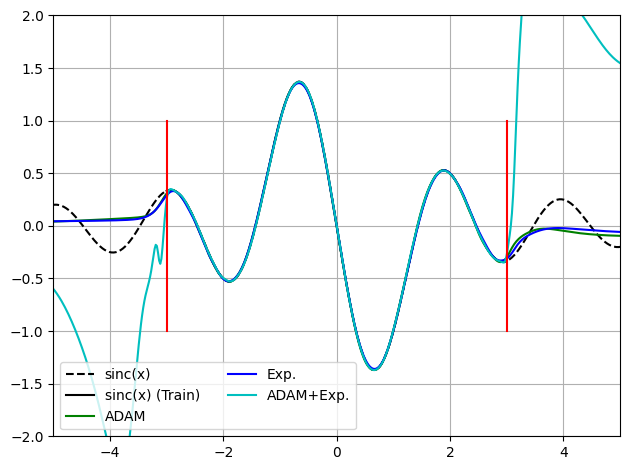

In [33]:
#jax.jacobian needed here for some reason, shape recasting was raising errors
newnet_preds2g = jax.vmap(jax.jacobian(newnet))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetExp_preds2g = jax.vmap(jax.jacobian(newnetExp))(extrax[:, jnp.newaxis])[:, 0, 0]
newnet2_preds2g = jax.vmap(jax.jacobian(newnet2))(extrax[:, jnp.newaxis])[:, 0, 0]

#notice for jnp functions, jax.grad works as intended
grefs = jax.vmap(jax.grad(jnp.sinc))(inps)
grefsx = jax.vmap(jax.grad(jnp.sinc))(extrax)

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)
plt.plot(extrax, grefsx, 'k--', label='sinc(x)')
plt.plot(inps, grefs, 'k-', label='sinc(x) (Train)')
plt.plot(extrax, newnet_preds2g, 'g-', label='ADAM')
plt.plot(extrax, newnetExp_preds2g, 'b-', label='Exp.')
plt.plot(extrax, newnet2_preds2g, 'c-', label='ADAM+Exp.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.legend(ncol=2)
plt.grid()
plt.tight_layout()

A cursory glance shows the trained region has well-captured the derivatives, but it certainly doesn't generalize well at all.

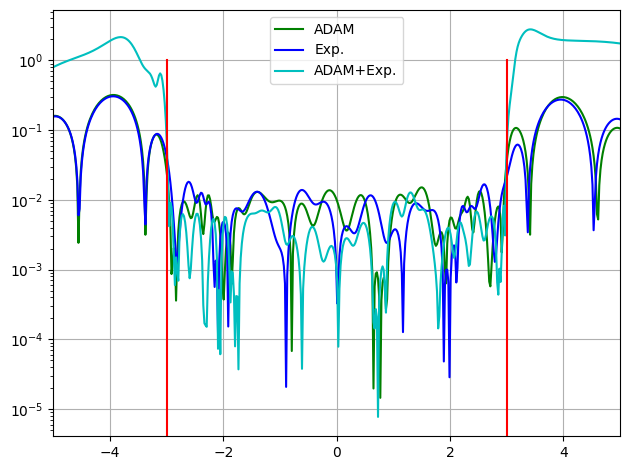

In [34]:
newnet_preds2g = jax.vmap(jax.jacobian(newnet))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetExp_preds2g = jax.vmap(jax.jacobian(newnetExp))(extrax[:, jnp.newaxis])[:, 0, 0]
newnet2_preds2g = jax.vmap(jax.jacobian(newnet2))(extrax[:, jnp.newaxis])[:, 0, 0]

grefs = jax.vmap(jax.grad(jnp.sinc))(inps)
grefsx = jax.vmap(jax.grad(jnp.sinc))(extrax)

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, abs(newnet_preds2g-grefsx), 'g-', label='ADAM')
plt.plot(extrax, abs(newnetExp_preds2g-grefsx), 'b-', label='Exp.')
plt.plot(extrax, abs(newnet2_preds2g-grefsx), 'c-', label='ADAM+Exp.')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
# plt.ylim(-2, 2)
plt.yscale('log')
plt.legend()
plt.grid()
plt.tight_layout()

# A Constraint
What if now, since we know that $\\sinc(x)\sim x^{-1}$, we enforce such a constraint by enveloping the network output? Will it generalize better? What about if we add in knowledge of the even-symmetry of the function?

In [35]:
class sincNetC(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        return self.net(inp)/(inp+self.zoff)

class sincNetC2(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        #as well as enforce the even symmetry: f(-x) = f(x) so just use the absolute value of the input
        return self.net(jnp.abs(inp))/(jnp.abs(inp)+self.zoff)

class sincNetC3(eqx.Module):
    depth: int
    nodes: int
    seed: int
    zoff: float
    net: eqx.nn.MLP
    
    def __init__(self, depth, nodes, seed, zoff=1e-8):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.zoff = zoff
        self.net = eqx.nn.MLP(in_size = 1,
                 out_size = 1,
                 depth = self.depth,
                 width_size = self.nodes,
                 activation = jax.nn.gelu,
                 key = jax.random.PRNGKey(self.seed))

    def __call__(self, inp):
        #the network is expecting a single input, so we use jax.vmap to broadcast the calculation 
        # across the input array
        #here we envelope the network output with 1/x
        #as well as enforce the even symmetry: f(-x) = f(x) so just use the absolute value of the input
        #as well as f(0) = 1
        def false_func(inp):
            return jnp.sinc(inp)
        def true_func(inp):
            return self.net(jnp.abs(inp))/(jnp.abs(inp)+self.zoff)
        #this tests the input value -- if zero, the input is sent to the false_func
        result = jax.lax.cond(inp[0], true_func, false_func, inp) 
        return result


netc = sincNetC(depth=DEPTH, nodes=NODES, seed=SEED)
netc2 = sincNetC2(depth=DEPTH, nodes=NODES, seed=SEED)
netc3 = sincNetC3(depth=DEPTH, nodes=NODES, seed=SEED)

In [36]:
MAGNITUDE = 3
NPTS = 200
inps = jnp.linspace(-MAGNITUDE, MAGNITUDE, num = NPTS, endpoint = True)
refs = jnp.sinc(inps)
grefs = jax.vmap(jax.grad(jnp.sinc))(inps)

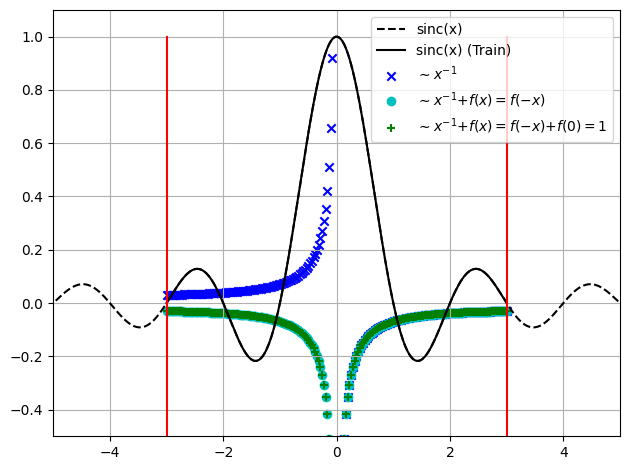

In [37]:
#jnp.newaxis just gives the inps array a shape of (NPTS, 1) instead of (NPTS,)
init_predsc = jax.vmap(netc)(inps[:, jnp.newaxis])
init_predsc2 = jax.vmap(netc2)(inps[:, jnp.newaxis])
#can't vmap across a jax.lax.cond for some reason
init_predsc3 = [netc3(x) for x in inps[:, jnp.newaxis]]
extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, jnp.sinc(extrax), 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.scatter(inps, init_predsc, color='b', marker='x', label='$\sim x^{-1}$')
plt.scatter(inps, init_predsc2, color='c', marker='o', label='$\sim x^{-1}$+$f(x)=f(-x)$')
plt.scatter(inps, init_predsc3, color='g', marker='+', label='$\sim x^{-1}$+$f(x)=f(-x)$+$f(0)=1$')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.5, 1.1)
plt.legend()
plt.grid()
plt.tight_layout()

For brevity, we will just train one of each new type of network now.

In [38]:
LR = 0.01
EPOCHS = 25000
DECAYSTART = EPOCHS//10
TRANSITION_STEPS = EPOCHS-DECAYSTART
DECAY_RATE = 0.8
scheduler = optax.exponential_decay(init_value = LR, transition_begin=DECAYSTART,
                                    transition_steps = TRANSITION_STEPS,
                                    decay_rate = DECAY_RATE)
optimExp = optax.adam(learning_rate = scheduler)
newnetc, lossesc = loop(netc, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)
newnetc2, lossesc2 = loop(netc2, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)
newnetc3, lossesc3 = loop(netc3, inps[:, jnp.newaxis], refs[:, jnp.newaxis], optimExp, epochs=EPOCHS)

Epoch 0: Loss = 0.6488654017448425
Epoch 2500: Loss = 0.007594567723572254
Epoch 5000: Loss = 0.014581975527107716
Epoch 7500: Loss = 0.014444291591644287
Epoch 10000: Loss = 0.008572953753173351
Epoch 12500: Loss = 0.008640562184154987
Epoch 15000: Loss = 0.009426298551261425
Epoch 17500: Loss = 0.01128313783556223
Epoch 20000: Loss = 0.004398403223603964
Epoch 22500: Loss = 0.0043708644807338715
Epoch 0: Loss = 0.7998608946800232
Epoch 2500: Loss = 0.009932818822562695
Epoch 5000: Loss = 0.010617553256452084
Epoch 7500: Loss = 0.010041257366538048
Epoch 10000: Loss = 0.00402441481128335
Epoch 12500: Loss = 0.00924062542617321
Epoch 15000: Loss = 0.009758271276950836
Epoch 17500: Loss = 0.00881236419081688
Epoch 20000: Loss = 0.00842966791242361
Epoch 22500: Loss = 0.0030644407961517572
Epoch 0: Loss = 0.7998608946800232
Epoch 2500: Loss = 0.012060818262398243
Epoch 5000: Loss = 0.007151917088776827
Epoch 7500: Loss = 0.006881481036543846
Epoch 10000: Loss = 0.007202122360467911
Epoch

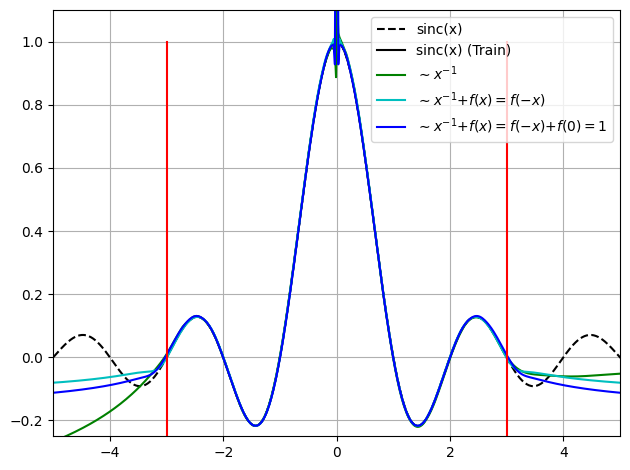

In [39]:
newnetc_preds = jax.vmap(newnetc)(extrax[:, jnp.newaxis])
newnetc2_preds = jax.vmap(newnetc2)(extrax[:, jnp.newaxis])
newnetc3_preds = [newnetc3(x) for x in extrax[:, jnp.newaxis]]

extrax = jnp.linspace(-10, 10, num=1000)
verty = jnp.linspace(-1, 1)
onesy = jnp.ones_like(verty)

plt.plot(extrax, extray, 'k--', label='sinc(x)')
plt.plot(inps, refs, 'k-', label='sinc(x) (Train)')
plt.plot(extrax, newnetc_preds, 'g-', label='$\sim x^{-1}$')
plt.plot(extrax, newnetc2_preds, 'c-', label='$\sim x^{-1}$+$f(x)=f(-x)$')
plt.plot(extrax, newnetc3_preds, 'b-', label='$\sim x^{-1}$+$f(x)=f(-x)$+$f(0)=1$')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.ylim(-0.25, 1.1)
plt.legend()
plt.grid()
plt.tight_layout()

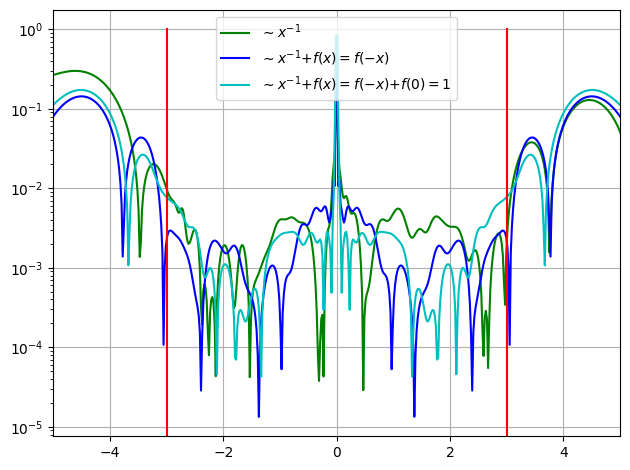

In [40]:
plt.plot(extrax, jnp.abs(newnetc_preds-extray[:, jnp.newaxis]), 'g-', label='$\sim x^{-1}$')
plt.plot(extrax, jnp.abs(newnetc2_preds-extray[:, jnp.newaxis]), 'b-', label='$\sim x^{-1}$+$f(x)=f(-x)$')
plt.plot(extrax, jnp.abs(jnp.array(newnetc3_preds)-extray[:, jnp.newaxis]), 'c-', label='$\sim x^{-1}$+$f(x)=f(-x)$+$f(0)=1$')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-5, 5)
plt.yscale('log')
# plt.ylim(-0.25, 1.1)
plt.grid()
plt.legend()
plt.tight_layout()

So the constraints bring down the generalization error in the outer regions.

In [41]:
newnetc_predsg = jax.vmap(jax.jacobian(newnetc))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetc2_predsg = jax.vmap(jax.jacobian(newnetc2))(extrax[:, jnp.newaxis])[:, 0, 0]
newnetc3_predsg = jax.vmap(jax.jacobian(newnetc3))(extrax[:, jnp.newaxis])[:, 0, 0]

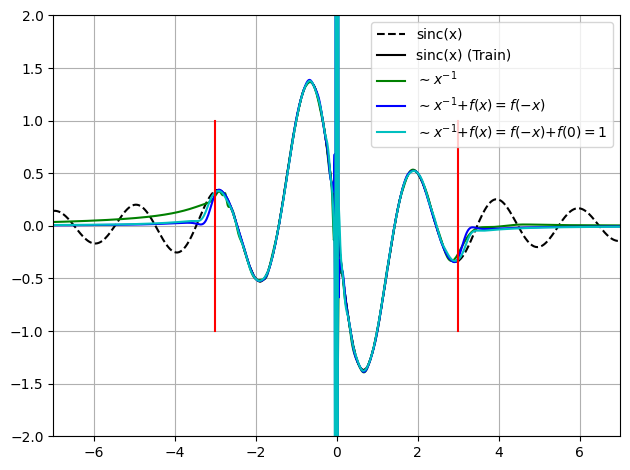

In [42]:
plt.plot(extrax, grefsx, 'k--', label='sinc(x)')
plt.plot(inps, grefs, 'k-', label='sinc(x) (Train)')
plt.plot(extrax, newnetc_predsg, 'g-', label='$\sim x^{-1}$')
plt.plot(extrax, newnetc2_predsg, 'b-', label='$\sim x^{-1}$+$f(x)=f(-x)$')
plt.plot(extrax, newnetc3_predsg, 'c-', label='$\sim x^{-1}$+$f(x)=f(-x)$+$f(0)=1$')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-7, 7)
plt.ylim(-2, 2)
plt.legend()
plt.grid()
plt.tight_layout()

Now we see, however, that the gradients in the regions beyond the bounded training region are much "better," despite still not being that great.

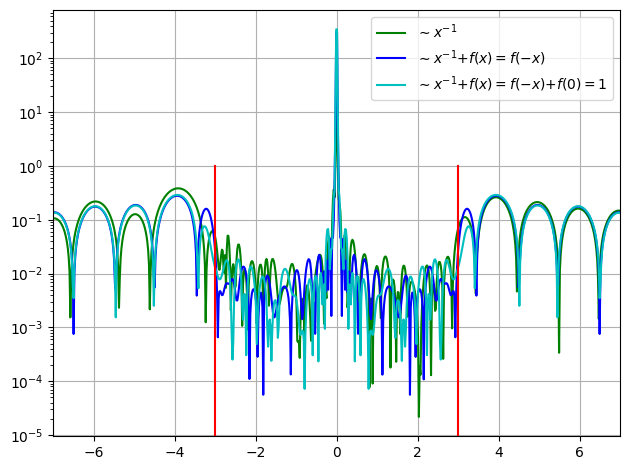

In [43]:
plt.plot(extrax, abs(newnetc_predsg-grefsx), 'g-', label='$\sim x^{-1}$')
plt.plot(extrax, abs(newnetc2_predsg-grefsx), 'b-', label='$\sim x^{-1}$+$f(x)=f(-x)$')
plt.plot(extrax, abs(newnetc3_predsg-grefsx), 'c-', label='$\sim x^{-1}$+$f(x)=f(-x)$+$f(0)=1$')
plt.plot(-MAGNITUDE*onesy, verty, 'r-')
plt.plot(MAGNITUDE*onesy, verty, 'r-')
plt.xlim(-7, 7)
# plt.ylim(-2, 2)
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()

So while the constraints (via the way we enforced them) give worse results for some regions of the bounded training region, the generalization extends to the outer regions in a much more accurate manner. Some better manner of enforcing the constraints is warranted, particularly the limiting behavior as x -> 0.